In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

In [2]:
train = pd.read_csv('contest_train.csv')
test = pd.read_csv('contest_test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
train.shape, test.shape

((210000, 32), (90000, 31))

In [4]:
X = train.drop(columns=['id', 'target'])
y = train['target']

In [5]:
cat_features = X.select_dtypes(include='object').columns.tolist()
len(cat_features)

19

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [7]:
results = []

seeds = [42, 2024, 777, 13, 99]
test_probas = []

# обязательно
X_test = test.drop(columns=['id'])

for seed in seeds:
    model = CatBoostClassifier(
        iterations=1200,
        depth=8,
        learning_rate=0.05,
        l2_leaf_reg=3,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=seed,
        verbose=0
    )

    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        use_best_model=True
    )

    # AUC на валидации
    val_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_proba)

    results.append({
        'seed': seed,
        'auc': auc
    })

# таблица сравнения seed
results_df = pd.DataFrame(results).sort_values('auc', ascending=False)
results_df

,seed,auc
2,777,0.892476
3,13,0.892410
1,2024,0.892403
4,99,0.892324
0,42,0.892270


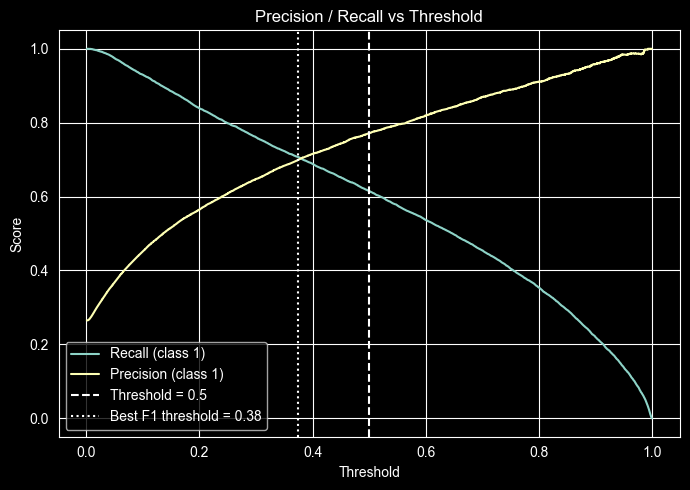

Best threshold (by F1): 0.375
Best F1-score: 0.703


In [8]:
# Precision–Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_val, val_proba)

# Подбор порога по F1
thresholds = np.linspace(0.0, 1.0, 201)

best_threshold = 0.0
best_f1 = 0.0

for t in thresholds:
    y_pred_t = (val_proba >= t).astype(int)
    f1 = f1_score(y_val, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# ===== Plot =====
plt.figure(figsize=(7, 5))

plt.plot(pr_thresholds, recall[:-1], label='Recall (class 1)')
plt.plot(pr_thresholds, precision[:-1], label='Precision (class 1)')

plt.axvline(0.5, linestyle='--', label='Threshold = 0.5')
plt.axvline(best_threshold, linestyle=':', label=f'Best F1 threshold = {best_threshold:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== Result =====
print(f"Best threshold (by F1): {best_threshold:.3f}")
print(f"Best F1-score: {best_f1:.3f}")

In [9]:
threshold = best_threshold
y_pred = (val_proba >= threshold).astype(int)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification report:\n", classification_report(y_val, y_pred))

Accuracy: 0.842
Confusion matrix:
 [[27502  3373]
 [ 3263  7862]]

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89     30875
           1       0.70      0.71      0.70     11125

    accuracy                           0.84     42000
   macro avg       0.80      0.80      0.80     42000
weighted avg       0.84      0.84      0.84     42000



In [10]:
# Data
X_full = train.drop(columns=['id', 'target'])
y_full = train['target']

cat_features = X_full.select_dtypes(include='object').columns.tolist()


final_model = CatBoostClassifier(
    iterations=1200,          # можно 1000–1200
    depth=8,
    learning_rate=0.05,
    l2_leaf_reg=3,            # дефолт ок, можно потом попробовать 5–10
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)

final_model.fit(
    X_full,
    y_full,
    cat_features=cat_features
)

0:	total: 90.8ms	remaining: 1m 48s
100:	total: 8.56s	remaining: 1m 33s
200:	total: 17.2s	remaining: 1m 25s
300:	total: 25.9s	remaining: 1m 17s
400:	total: 34.4s	remaining: 1m 8s
500:	total: 43s	remaining: 1m
600:	total: 51.7s	remaining: 51.5s
700:	total: 1m	remaining: 43.1s
800:	total: 1m 9s	remaining: 34.4s
900:	total: 1m 17s	remaining: 25.8s
1000:	total: 1m 26s	remaining: 17.2s
1100:	total: 1m 35s	remaining: 8.57s
1199:	total: 1m 43s	remaining: 0us


In [11]:
X_test = test.drop(columns=['id'])

test_proba = final_model.predict_proba(X_test)[:, 1]

In [12]:
submission = pd.DataFrame({
    'id': test['id'],
    'target': test_proba
})

submission.to_csv('submission.csv', index=False)
submission

,id,target
0,0,0.012007
1,1,0.117374
2,2,0.694692
3,3,0.026498
4,4,0.293341
...,...,...
89995,89995,0.066895
89996,89996,0.036317
89997,89997,0.029637
89998,89998,0.087281


In [13]:
submission.shape

(90000, 2)

In [14]:
submission['target'].min(), submission['target'].max()

(np.float64(0.0009341089027921026), np.float64(0.9999270197883364))

In [15]:
submission.isna().sum()

id        0
target    0
dtype: int64